## Импорты

In [1]:
#!pip install optuna

In [1]:
#!pip install ydata-profiling
#!pip install lightgbm 
#!pip install optuna

In [3]:
RANDOM_STATE = 220523

In [4]:
import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split , cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

import catboost as cb

from sklearn.preprocessing import OrdinalEncoder

# Project description

<font color='green' style='font-size:24px; font-weight:bold'>Project Telecom</font>

The telecom operator "Niedinogorazryva.com" wants to learn how to predict the outflow of customers. If it turns out that the user plans to leave, he will be offered promotional codes and special conditions. The operator's team collected personal data about some customers, information about their tariffs and contracts.

The operator provides two main types of services:

1. Fixed telephone connection. It is possible to connect a telephone set to several lines at the same time.
2. Internet. The connection can be of two types: via a telephone line (DSL *, * from the English * digital subscriber line *, "digital subscriber line") or fiber optic cable (* Fiber optic *).

The following services are also available:

- Internet security: antivirus (*DeviceProtection*) and blocking of unsafe sites (*OnlineSecurity*);
- Dedicated technical support line (*TechSupport*);
- Cloud file storage for data backup (*OnlineBackup*);
- Streaming TV (*StreamingTV*) and movie catalog (*StreamingMovies*).

Clients can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic check are available.

Data Description

The data consists of files obtained from various sources:

- `contract_new.csv` - information about the contract;
- `personal_new.csv` - personal data of the client;
- `internet_new.csv` - information about Internet services;
- `phone_new.csv` - information about telephony services.

In all files, the `customerID` column contains the customer ID.

Information about contracts is current as of February 1, 2020.

# Download and review

## Loading stage

In [5]:
data_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')

data_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')

data_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')

data_phone_new = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [6]:
data_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
data_personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
data_internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
data_phone_new.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Conclusion:** Loaded data, let's proceed to analysis one by one

## Analysis stage

We will use advanced methods for analyzing ProfileReport, unfortunately it will not run on the Yandex machine, since there is no access to changing the font, without this setting it crashes with an error

In [10]:
font_manager.findfont('Arial')  

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


'/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

### data_contract

In [11]:
data_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [2]:
#ProfileReport(data_contract)

Consider the target variable

Value 1 - the client left, value 0 - the client remained

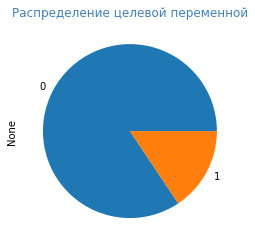

In [13]:
pd.Series(np.where(data_contract['EndDate']=='No', 0, 1)).value_counts().plot(kind='pie')\
                                        .set_title('Distribution of the target variable', fontsize = 12, color = 'SteelBlue') 
None

**Conclusion** As can be seen from the analysis, we have no complete duplicates, no missing values, there are both numerical (MonthlyCharges TotalCharges) and nominative values (customerID EndDate Type PaperlessBilling PaymentMethod), there are also BeginDate dates. Also, we do not have multi-coleniality, all variables have a certain relationship.

We have a disbalance of classes of clients who left - not enough. Since our metric is ROC-AUG, we can "leave it as is",
do not use class imbalance methods

### data_personal

In [14]:
data_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [3]:
#ProfileReport(data_personal)

Conclusion In this case, we have only naming features, no gaps, no full duplicates, no collinearity, but there are features that seem to have little effect, namely SeniorCitizen and gender. Naminative characters with two species are distributed equally, except Dependents

### data_internet

In [16]:
data_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [4]:
#ProfileReport(data_internet)

Conclusion In this case, we have the same name features, no gaps, no full duplicates, no collinearity.

### data_phone_new

In [18]:
data_phone_new.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [5]:
#ProfileReport(data_phone_new)

Conclusion In this case, one name feature, no gaps, no complete duplicates, it is also worth remembering that MultipleLines means that the possibility and not the presence

## Preliminary conclusion

Conclusion: We have loaded data, data without gaps, full of duplicates, we have a lot of nominal variables, since the data is divided into several tables, we will have to merge them.

We have a disbalance of classes of clients who left - not enough. Since our ROC-AUG metric, we can "leave it as it is", do not use class imbalance methods

# Merging samples

In [20]:
pd.options.display.max_columns = 25

In [21]:
data = data_contract.merge(data_personal, on='customerID', how='left')

In [22]:
data = data.merge(data_internet, on='customerID', how='left')

In [23]:
data = data.merge(data_phone_new, on='customerID', how='left')

## Problems with Nan

In [24]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Significant number of gaps found

### InternetService

A large number of gaps were found, most of them came to us from the data_internet table, perhaps this is due to the fact that they do not have an Internet connection in principle

In [25]:
data_internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Fill in the columns received from data_internet, No **also add the feature - no internet** internet

In [26]:
data['Internet'] = np.where(data['InternetService'].isna(), 'No', 'Yes')

In [27]:
data_internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [28]:
data[data_internet.columns] = data[data_internet.columns].fillna('No')

### MultipleLines

In [29]:
data[data['MultipleLines'].isna()].head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,Yes
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN,Yes
20,8779-QRDMV,2019-11-01,No,Month-to-month,Yes,Electronic check,39.65,118.95,Male,1,No,No,DSL,No,No,Yes,No,No,Yes,NaN,Yes
27,8665-UTDHZ,2019-11-01,No,Month-to-month,No,Electronic check,30.20,96.04,Male,0,Yes,Yes,DSL,No,Yes,No,No,No,No,NaN,Yes
62,0526-SXDJP,2014-02-01,No,Two year,No,Bank transfer (automatic),42.10,3304.01,Male,0,Yes,No,DSL,Yes,Yes,Yes,No,No,No,NaN,Yes
81,8108-UXRQN,2019-03-01,No,Month-to-month,No,Electronic check,50.55,600.53,Female,0,Yes,Yes,DSL,Yes,No,No,No,Yes,Yes,NaN,Yes
89,3016-KSVCP,2017-09-01,No,Month-to-month,No,Mailed check,33.75,978.75,Male,0,Yes,No,DSL,No,No,No,No,Yes,No,NaN,Yes
103,5386-THSLQ,2014-08-01,2016-06-01,One year,No,Bank transfer (automatic),45.55,1072.25,Female,1,Yes,No,DSL,No,Yes,Yes,No,Yes,No,NaN,Yes
105,6180-YBIQI,2019-09-01,No,Month-to-month,No,Mailed check,24.30,130.0,Male,0,No,No,DSL,No,No,No,No,No,No,NaN,Yes


In [30]:
data[data['Internet']=='Yes']['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [31]:
data[data['MultipleLines'].isna()]['InternetService'].value_counts()

DSL    682
Name: InternetService, dtype: int64

Все пропуски для DSL

In [32]:
data.query('InternetService=="DSL"')['MultipleLines'].value_counts()

No     1048
Yes     691
Name: MultipleLines, dtype: int64

Fill in the most common values

In [33]:
data['MultipleLines'] = data['MultipleLines'].fillna('No')

In [34]:
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
Internet            0
dtype: int64

### TotalCharges

In [35]:
data[data['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,Yes
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,No
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,Yes
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,No
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Yes


There are 11 values in total, there can be many different approaches to filling in errors, but there are only 11 values, you can simply remove them.

In [36]:
data = data[data['TotalCharges']!=' '].copy()

In [37]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [38]:
data['EndDate'] = np.where(data['EndDate']=='No', 0, 1)

**Conclusion:** all gaps filled

## Combined Value Analysis

In [39]:
data.describe()

,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.156570,64.798208,2118.621822,0.162400
std,0.363421,30.085974,2112.736199,0.368844
min,0.000000,18.250000,19.050000,0.000000
25%,0.000000,35.587500,439.745000,0.000000
50%,0.000000,70.350000,1345.275000,0.000000
75%,0.000000,89.862500,3239.317500,0.000000
max,1.000000,118.750000,9221.380000,1.000000


In [40]:
data[data.duplicated('customerID')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet


Дубли не появились

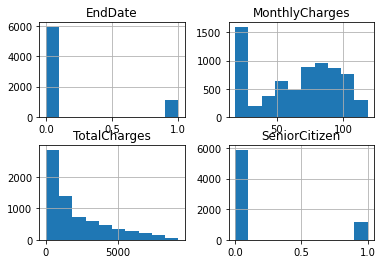

In [41]:
data.hist()
None

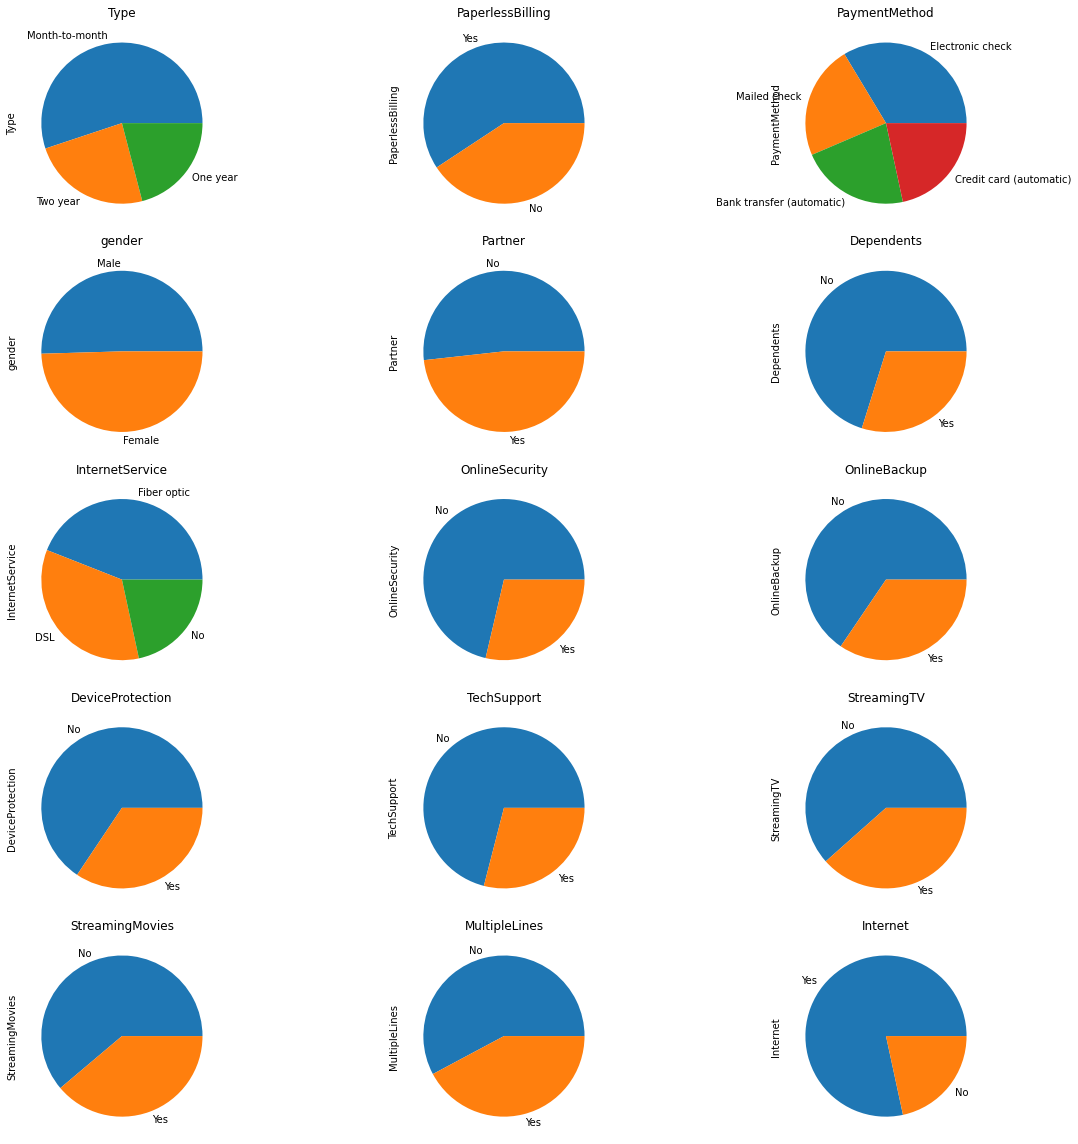

In [42]:
l = data.select_dtypes(exclude=['float64', 'int64']).columns.to_list()

list_cat = [
'Type',
'PaperlessBilling',
'PaymentMethod',
'gender',
'Partner',
'Dependents',
'InternetService',
'OnlineSecurity',
'OnlineBackup',
'DeviceProtection',
'TechSupport',
'StreamingTV',
'StreamingMovies',
'MultipleLines',
'Internet']



fig = plt.figure(figsize=(20,16))
for i in range(len(list_cat)):
    fig.add_subplot(5, 3, i+1)
    data[list_cat[i]].value_counts().plot(kind='pie')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(list_cat[i])

In [43]:
data.drop(columns=['customerID', 'BeginDate']).corrwith(data['EndDate'])

EndDate           1.000000
MonthlyCharges    0.153927
TotalCharges      0.051548
SeniorCitizen     0.056444
dtype: float64

Correlation is not strong

# Feature engineering

Let's add a feature - the duration of the contract. Discharge date - Contract start date

In [44]:
date_end = pd.to_datetime('2020-02-01').date()

In [45]:
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.date

In [46]:
data['ContractDurable']  = date_end - data['BeginDate'] 

data['ContractDurable'] = data['ContractDurable'].dt.days

Add contract start month

In [47]:
data['MonthContract'] = data['BeginDate'].map(lambda x: x.month)

# Collinearity analysis

In [48]:
data_test = data[[
        'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Internet', 'MonthContract', 'ContractDurable', ]].copy()

We will also analyze the collinarity of features consisting of two features

In [ ]:
data_test.head()

,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,MonthContract,ContractDurable
0,29.85,31.04,Female,0,Yes,No,No,Yes,No,No,No,No,No,Yes,1,31
1,56.95,2071.84,Male,0,No,No,Yes,No,Yes,No,No,No,No,Yes,4,1036
2,53.85,226.17,Male,0,No,No,Yes,Yes,No,No,No,No,No,Yes,10,123
3,42.30,1960.60,Male,0,No,No,Yes,No,Yes,Yes,No,No,No,Yes,5,1371
4,70.70,353.50,Female,0,No,No,No,No,No,No,No,No,No,Yes,9,153


In [50]:
data_test = pd.get_dummies(data_test, drop_first=True,)

In [51]:
X = add_constant(data_test)


vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
  
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [52]:
vif_df

,feature,VIF
0,const,17.352321
1,MonthlyCharges,6.458566
2,TotalCharges,4.762868
3,SeniorCitizen,1.133143
4,MonthContract,1.069030
5,ContractDurable,3.346098
6,gender_Male,1.001271
7,Partner_Yes,1.462583
8,Dependents_Yes,1.369415
9,OnlineSecurity_Yes,1.357463


It is worth paying attention to MonthlyCharges, it is collinear, we can remove it!

In [53]:
data = data.drop(columns='MonthlyCharges')

# Dividing into samples

In [54]:
features = data.drop(columns= ['EndDate', 'customerID', 'BeginDate'])
target = data['EndDate']

Let's translate Type from nominative to numerical values

In [55]:
features['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [56]:
dict(zip(features['Type'].unique(), [30, 365, 365*2]))

{'Month-to-month': 30, 'One year': 365, 'Two year': 730}

In [57]:
d_type = dict(zip(features['Type'].unique(), [30, 365, 365*2]))

In [58]:
features['Type'] = features['Type'].map(d_type)

Let's replace it with a more understandable interpretation

In [59]:
features['SeniorCitizen'] = np.where(features['SeniorCitizen']==0, 'No', 'Yes')

In [60]:
features_train, features_valid, target_train, target_valid = train_test_split(
                                                features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

Divide into categorical and non-categorical features

In [61]:
features.head(3)

,Type,PaperlessBilling,PaymentMethod,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,ContractDurable,MonthContract
0,30,Yes,Electronic check,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No,Yes,31,1
1,365,No,Mailed check,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,Yes,1036,4
2,30,Yes,Mailed check,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes,123,10


In [62]:
 features.select_dtypes(include='object').columns.to_list()

['PaperlessBilling',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'Internet']

In [63]:
categorical_features = features.select_dtypes(include='object').columns.to_list()

In [64]:
categorical_features.extend(['Type', 'MonthContract'])

In [66]:
# Find index by name
index_categorical_features = [features.columns.to_list().index(col) for col in categorical_features]

**Conclusion:** We divided it into samples and did not do the encoding, since we will use catboost, and we got indexes of categorical features. Also translated Type into a numerical representation. We designated 1 as the target when the person left and we know the date end_date. Also, when separating the samples, we made stratifay with the target argument

# Training

Let's add for clarity

In [67]:
df_lehr = pd.DataFrame(columns=['type', 'best_value', 'best_params'])

In [68]:
df_lehr

,type,best_value,best_params


## Training 1

In [ ]:
study.best_value

In [ ]:
study.best_params

1412:	learn: 0.1076514	total: 44.7s	remaining: 18.6s


Best score 0.958
with parameters {'iterations': 1701, 'depth': 5, 'l2_leaf_reg': 0.021924627425926664}

Let's add a date frame for clarity

In [ ]:
df_lehr = pd.concat([df_lehr, 
                    pd.DataFrame(dict(zip(df_lehr.columns, ['Cat_boost', study.best_value, [study.best_params]])))])

In [ ]:
df_lehr

## Trainning 2

In [71]:
X_train = features_train.copy()
y_train = target_train.copy()

X_valid = features_valid.copy()
y_valid = target_valid.copy()

1359:	learn: 0.1030794	total: 43s	remaining: 16.1s
1943:	learn: 0.0863537	total: 1m 1s	remaining: 1.74s
1674:	learn: 0.0942128	total: 53.8s	remaining: 10.4s
484:	learn: 0.1971514	total: 16.5s	remaining: 49.3s
529:	learn: 0.1832737	total: 16.4s	remaining: 43.3s
734:	learn: 0.1655954	total: 23.4s	remaining: 38.1s
843:	learn: 0.1525560	total: 25.9s	remaining: 33.3s
735:	learn: 0.1654976	total: 23.4s	remaining: 38s
1360:	learn: 0.1030354	total: 43s	remaining: 16.1s
485:	learn: 0.1970739	total: 16.5s	remaining: 49.1s
1675:	learn: 0.0941605	total: 53.8s	remaining: 10.4s
844:	learn: 0.1525014	total: 25.9s	remaining: 33.3s
1361:	learn: 0.1029790	total: 43s	remaining: 16.1s
530:	learn: 0.1830224	total: 16.4s	remaining: 43.3s
1944:	learn: 0.0863311	total: 1m 1s	remaining: 1.71s
736:	learn: 0.1654063	total: 23.4s	remaining: 38s
486:	learn: 0.1970109	total: 16.5s	remaining: 49s
531:	learn: 0.1830220	total: 16.4s	remaining: 43.2s
1945:	learn: 0.0862875	total: 1m 1s	remaining: 1.68s
1676:	learn: 0.0

[I 2023-05-29 09:14:27,934] Trial 87 finished with value: 0.9572793574025615 and parameters: {'iterations': 1999, 'depth': 5, 'l2_leaf_reg': 0.2843903626555165}. Best is trial 83 with value: 0.9583485329287332.


804:	learn: 0.1585940	total: 25.1s	remaining: 35.2s
earn: 0.1232322	total: 36s	remaining: 26.1s
301:	learn: 0.2188266	total: 8.25s	remaining: 44.5s
847:	learn: 0.1476089	total: 24.5s	remaining: 29.5s
1919:	learn: 0.0881561	total: 1m 1s	remaining: 352ms
207:	learn: 0.2529624	total: 5.6s	remaining: 46.4s
208:	learn: 0.2525075	total: 5.66s	remaining: 46.7s
303:	learn: 0.2182950	total: 8.27s	remaining: 44.2s
1442:	learn: 0.1090551	total: 44.1s	remaining: 17s
1920:	learn: 0.0881225	total: 1m 1s	remaining: 321ms
304:	learn: 0.2182669	total: 8.27s	remaining: 44.1s
1443:	learn: 0.1089810	total: 44.1s	remaining: 17s
1160:	learn: 0.1231172	total: 36s	remaining: 26s
1457:	learn: 0.1101231	total: 45.7s	remaining: 14.8s
849:	learn: 0.1473691	total: 24.6s	remaining: 29.5s
305:	learn: 0.2178812	total: 8.28s	remaining: 44s
1161:	learn: 0.1230708	total: 36s	remaining: 25.9s
306:	learn: 0.2175272	total: 8.28s	remaining: 43.8s
1162:	learn: 0.1229707	total: 36s	remaining: 25.9s
209:	learn: 0.2521280	total

We will do ordinary encoding, since LightGBM only accepts ints and floats, we will not do OneHot encoding since it is built into LightGBM

In [72]:
l_f_encode = X_train.select_dtypes(include='object').columns.to_list()

1m 1s	remaining: 1.07s
313:	learn: 0.2128408	total: 6.75s	remaining: 34.7s
314:	learn: 0.2125154	total: 6.75s	remaining: 34.7s
1965:	learn: 0.0823734	total: 1m 1s	remaining: 1.04s
842:	learn: 0.1538191	total: 23.7s	remaining: 30.5s
315:	learn: 0.2123357	total: 6.76s	remaining: 34.6s
797:	learn: 0.1630063	total: 23.9s	remaining: 34s
1017:	learn: 0.1388877	total: 30.9s	remaining: 27.8s
1653:	learn: 0.0872401	total: 50.7s	remaining: 6.65s
316:	learn: 0.2120910	total: 6.77s	remaining: 34.5s
1966:	learn: 0.0823241	total: 1m 1s	remaining: 1s
798:	learn: 0.1628703	total: 23.9s	remaining: 33.9s
1134:	learn: 0.1255151	total: 33.7s	remaining: 23.6s
843:	learn: 0.1538142	total: 23.7s	remaining: 30.5s
1135:	learn: 0.1254870	total: 33.7s	remaining: 23.6s
1654:	learn: 0.0872123	total: 50.7s	remaining: 6.62s
317:	learn: 0.2117575	total: 6.83s	remaining: 34.6s
1018:	learn: 0.1387737	total: 31s	remaining: 27.8s
1967:	learn: 0.0823014	total: 1m 1s	remaining: 975ms
844:	learn: 0.1537326	total: 23.7s	rema

[I 2023-05-29 09:14:42,133] Trial 88 finished with value: 0.9572949137517139 and parameters: {'iterations': 1999, 'depth': 5, 'l2_leaf_reg': 0.1832040967115292}. Best is trial 83 with value: 0.9583485329287332.


In [73]:
X_valid[l_f_encode].head(5)

,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet
4546,Yes,Electronic check,Female,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,Yes,Yes
4038,No,Mailed check,Female,No,No,No,No,No,No,No,No,No,No,No,No
6871,No,Bank transfer (automatic),Female,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Yes,Yes
1680,Yes,Mailed check,Male,No,Yes,Yes,No,No,No,No,No,No,No,Yes,No
910,Yes,Electronic check,Male,Yes,No,No,Fiber optic,No,Yes,No,No,No,No,No,Yes


In [76]:
l_f_encode

['PaperlessBilling',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'Internet']

In [74]:
encoder = OrdinalEncoder()


encoder.fit(X_train[l_f_encode])

X_train[l_f_encode] = encoder.transform(X_train[l_f_encode])
X_valid[l_f_encode] = encoder.transform(X_valid[l_f_encode])

In [75]:
X_train.head(5)

,Type,PaperlessBilling,PaymentMethod,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,ContractDurable,MonthContract
4096,30,1.0,0.0,1913.16,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,610,6
5423,30,1.0,2.0,1212.75,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,457,11
3628,30,1.0,3.0,625.50,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,276,5
992,730,0.0,1.0,577.72,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,671,4
2640,30,1.0,0.0,2088.90,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,671,4


[I 2023-05-29 09:14:51,139] Trial 89 finished with value: 0.9565089908477901 and parameters: {'iterations': 1871, 'depth': 5, 'l2_leaf_reg': 0.027151558185856944}. Best is trial 83 with value: 0.9583485329287332.
[I 2023-05-29 09:15:12,456] Trial 90 finished with value: 0.9580189768609865 and parameters: {'iterations': 1931, 'depth': 5, 'l2_leaf_reg': 0.1910129195098648}. Best is trial 83 with value: 0.9583485329287332.


1793:	learn: 0.0912604	total: 43.3s	remaining: 3.28s
1763:	learn: 0.0957001	total: 43.9s	remaining: 4.16s
1794:	learn: 0.0911975	total: 43.3s	remaining: 3.26s
1312:	learn: 0.1151543	total: 25.9s	remaining: 12.2s
1764:	learn: 0.0956389	total: 43.9s	remaining: 4.13s
1795:	learn: 0.0911554	total: 43.3s	remaining: 3.23s
1313:	learn: 0.1150826	total: 25.9s	remaining: 12.2s
1314:	learn: 0.1150411	total: 25.9s	remaining: 12.1s
1765:	learn: 0.0955997	total: 44s	remaining: 4.11s
1315:	learn: 0.1149710	total: 25.9s	remaining: 12.1s
1796:	learn: 0.0911319	total: 43.4s	remaining: 3.21s
1766:	learn: 0.0955676	total: 44s	remaining: 4.08s
1316:	learn: 0.1148844	total: 25.9s	remaining: 12.1s
1797:	learn: 0.0910719	total: 43.4s	remaining: 3.18s
1317:	learn: 0.1148299	total: 25.9s	remaining: 12.1s
1767:	learn: 0.0955395	total: 44s	remaining: 4.05s
1798:	learn: 0.0910317	total: 43.4s	remaining: 3.16s
1318:	learn: 0.1147720	total: 26s	remaining: 12s
1768:	learn: 0.0955144	total: 44s	remaining: 4.03s
1799:

[I 2023-05-29 09:15:20,994] Trial 91 finished with value: 0.9571325999502157 and parameters: {'iterations': 1930, 'depth': 5, 'l2_leaf_reg': 0.19805769374307722}. Best is trial 83 with value: 0.9583485329287332.


n: 0.0855327	total: 51.6s	remaining: 5.36s
887:	learn: 0.1488876	total: 24.7s	remaining: 29s
843:	learn: 0.1583252	total: 25s	remaining: 32.1s
1064:	learn: 0.1346103	total: 31.8s	remaining: 25.9s
1181:	learn: 0.1219523	total: 34.8s	remaining: 22s
366:	learn: 0.2026330	total: 7.74s	remaining: 33s
1695:	learn: 0.0854567	total: 51.6s	remaining: 5.32s
1065:	learn: 0.1344710	total: 31.8s	remaining: 25.9s
888:	learn: 0.1487897	total: 24.8s	remaining: 29s
844:	learn: 0.1582428	total: 25s	remaining: 32.1s
1182:	learn: 0.1218354	total: 34.8s	remaining: 22s
367:	learn: 0.2024922	total: 7.75s	remaining: 32.9s
1696:	learn: 0.0854285	total: 51.6s	remaining: 5.29s
1066:	learn: 0.1344285	total: 31.8s	remaining: 25.8s
1919:	learn: 0.0890905	total: 46.5s	remaining: 266ms
146:	learn: 0.3000087	total: 1.9s	remaining: 23s
1462:	learn: 0.1070328	total: 28.5s	remaining: 9.1s
1465:	learn: 0.1069078	total: 28.5s	remaining: 9.05s
150:	learn: 0.2961949	total: 1.95s	remaining: 23s
1923:	learn: 0.0889750	total: 4

[I 2023-05-29 09:15:32,768] Trial 92 finished with value: 0.957588926066261 and parameters: {'iterations': 1931, 'depth': 5, 'l2_leaf_reg': 0.23261633553621422}. Best is trial 83 with value: 0.9583485329287332.


ning: 21.5s
1491:	learn: 0.1056147	total: 28.7s	remaining: 8.46s
178:	learn: 0.2786003	total: 2.19s	remaining: 21.4s
179:	learn: 0.2781589	total: 2.19s	remaining: 21.3s
1492:	learn: 0.1055677	total: 28.8s	remaining: 8.44s
180:	learn: 0.2775173	total: 2.19s	remaining: 21.2s
181:	learn: 0.2773104	total: 2.2s	remaining: 21.1s
1493:	learn: 0.1055247	total: 28.8s	remaining: 8.41s
182:	learn: 0.2768133	total: 2.2s	remaining: 21.1s
1494:	learn: 0.1055062	total: 28.8s	remaining: 8.39s
183:	learn: 0.2762222	total: 2.22s	remaining: 21.1s
1495:	learn: 0.1054533	total: 28.8s	remaining: 8.37s
184:	learn: 0.2759507	total: 2.23s	remaining: 21.1s
185:	learn: 0.2755863	total: 2.25s	remaining: 21.1s
1496:	learn: 0.1053888	total: 28.8s	remaining: 8.35s
186:	learn: 0.2749685	total: 2.25s	remaining: 21s
187:	learn: 0.2749289	total: 2.25s	remaining: 20.9s
1497:	learn: 0.1053190	total: 28.8s	remaining: 8.33s
188:	learn: 0.2741758	total: 2.26s	remaining: 20.8s
189:	learn: 0.2740833	total: 2.26s	remaining: 20.

[I 2023-05-29 09:15:57,977] Trial 93 finished with value: 0.9576761985760612 and parameters: {'iterations': 1931, 'depth': 5, 'l2_leaf_reg': 0.21510259571764193}. Best is trial 83 with value: 0.9583485329287332.


94:	learn: 0.3278999	total: 673ms	remaining: 13s
95:	learn: 0.3263750	total: 680ms	remaining: 13s
96:	learn: 0.3250182	total: 686ms	remaining: 13s
97:	learn: 0.3246209	total: 689ms	remaining: 12.9s
98:	learn: 0.3229225	total: 696ms	remaining: 12.9s
99:	learn: 0.3215042	total: 704ms	remaining: 12.9s
100:	learn: 0.3199894	total: 710ms	remaining: 12.9s
101:	learn: 0.3196354	total: 713ms	remaining: 12.8s
102:	learn: 0.3182148	total: 721ms	remaining: 12.8s
103:	learn: 0.3168821	total: 728ms	remaining: 12.8s
104:	learn: 0.3153467	total: 736ms	remaining: 12.8s
4:	learn: 0.0923233	total: 18.6s	remaining: 1.98s
1926:	learn: 0.0899516	total: 21.4s	remaining: 66.7ms
1745:	learn: 0.0923025	total: 18.6s	remaining: 1.97s
1927:	learn: 0.0899303	total: 21.4s	remaining: 55.6ms
1746:	learn: 0.0922479	total: 18.6s	remaining: 1.96s
1747:	learn: 0.0922277	total: 18.6s	remaining: 1.95s
1928:	learn: 0.0898950	total: 21.4s	remaining: 44.5ms
1929:	learn: 0.0898473	total: 21.5s	remaining: 33.3ms
1748:	learn: 0.

[I 2023-05-29 09:16:12,369] Trial 94 finished with value: 0.95711618071314 and parameters: {'iterations': 1933, 'depth': 5, 'l2_leaf_reg': 0.27628580438601813}. Best is trial 83 with value: 0.9583485329287332.


In [79]:
study_2.best_value

0.9645555968056203

In [80]:
study_2.best_params

{'num_iterations': 1073, 'learning_rate': 0.13674576878728018, 'max_depth': 2}

Best score 0.964 with parameters {'num_iterations': 1133, 'learning_rate': 0.14240080132950503, 'max_depth': 2, 'l2_leaf_reg': 0.04412768503145259}

In [81]:
df_lehr = pd.concat([df_lehr, 
                    pd.DataFrame(dict(zip(df_lehr.columns, ['LightGBM', study_2.best_value, [study_2.best_params]])))],
                    ignore_index=True )

## Conclusion

In [82]:
df_lehr

,type,best_value,best_params
0,LightGBM,0.964556,"{'num_iterations': 1073, 'learning_rate': 0.13..."


The best result was shown by LightGBM, so we will train the data based on it

In [83]:
study.best_params

{'iterations': 2000, 'depth': 5, 'l2_leaf_reg': 0.13694454933785938}

In [84]:
best_model = lgb.LGBMClassifier(categorical_feature=index_categorical_features, **study_2.best_params)

In [85]:
best_model.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


LGBMClassifier(categorical_feature=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                    15, 16, 0, 18],
               learning_rate=0.13674576878728018, max_depth=2,
               num_iterations=1073)

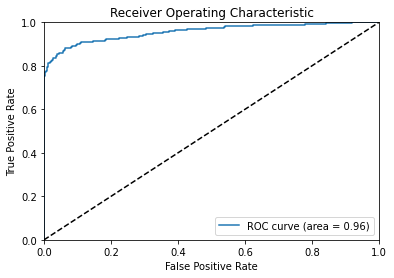

In [86]:
# Obtaining model predictions on the validation set
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(target_valid, y_pred_proba)

# Calculate the area under the ROC-AUC curve
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [87]:
# Obtaining model predictions on a test set
y_pred = best_model.predict(X_valid)

# Compute error matrix
cm = confusion_matrix(y_valid, y_pred)

# Output error matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1473   10]
 [  62  213]]


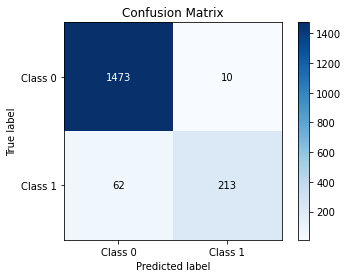

In [88]:
# Class names
class_names = ['Class 0', 'Class 1']

# Create figure and axes
fig, ax = plt.subplots()

# Building an error matrix
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Adjusting the axes
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add text with number of examples in cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Plot output
plt.show()


**Conclusion** based on the results of the study, we selected a model with ROC-AUG on a training set of 0.96, which meets the requirements of the TOR. LightGBM model parameters {'num_iterations': 909,
  'learning_rate': 0.15588723094396534,
  'max_depth': 2,
  'l2_leaf_reg': 4.7213623038058675e-05}

From the analysis of the error matrix, we can say that our model sometimes writes the first class into the zero one, but rarely writes the zero into the first one, which is actually bad, since we want to accurately determine exactly the 1st class as an option, increase the class assignment threshold.
 
 
You can also notice that the most important features are TotalCharges, ContractDurable, InternetService, the rest of the features have an extremely insignificant contribution.


In [93]:
feature_importances = best_model.feature_importances_

# Вывод значимости фич
df_feature = pd.DataFrame(zip(features_train.columns, feature_importances), columns=['Фича', 'Значение'])

In [94]:
df_feature.sort_values('Значение', ascending=False)

,Фича,Значение
3,TotalCharges,1394
17,ContractDurable,796
8,InternetService,313
18,MonthContract,119
15,MultipleLines,115
14,StreamingMovies,89
13,StreamingTV,85
11,DeviceProtection,50
10,OnlineBackup,46
9,OnlineSecurity,39
